In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int']#, 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 1000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
l = n_variaveis-1
tam_janela = n_variaveis*janela
n_entradas = n_variaveis * janela + 2 #ncont, valor e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
lim_cont = 5
n_saidas = 2*lim_cont+1   #numero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
dias = 220

caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
print(inputs['preco'][0:2])
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0
n_steps = 106 #especifico pra 5min
for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = np.amax(hr)
batch = step_max + 1

#normalizacao dos dados
hr = hr/step_max
inputs['hr_int'] = hr
pmean = np.mean( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor minimo do preco  #step = 106
pstd = np.std( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor maximo do preco
for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imean = np.mean( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor maximo
    istd = np.std( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor minimo
    
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imean ) / istd #normaliza prs
    
mini_batch_size = int(dias*batch*0.1)

0    3907.5
1    3900.0
Name: preco, dtype: float64


D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import backend as K            #importa backend para clear_session()


##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria_dia()
        self.limpa_memoria_epoca()
        self.gamma = 0.97       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-4
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []
        self.janela_precos = []
        self.prox_janela_precos = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(320, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(256, activation='relu')) #camada escondida
        model.add(Dense(256, activation='relu')) #camada escondida
        model.add(Dense(256, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        #model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        sgd = optimizers.SGD(lr=self.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd)
        return model

    def limpa_memoria_dia(self):
        self.janela_precos = np.zeros(n_variaveis*janela)
        self.prox_janela_precos = np.zeros(n_variaveis*janela)
        self.state = []
        self.next_state = []
    
    def limpa_memoria_epoca(self):
        self.memory = []
        
    def toma_acao(self):
        if np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria     
        act_values = self.model.predict(self.state) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=mini_batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        x = np.zeros((batch_size+1, self.state_size))
        y = np.zeros((batch_size+1, self.action_size))
        i = 0
        for acao, reward, estado, prox_estado, done in minibatch:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(prox_estado)[0])) #pega valor que quer chegar

            target_f = self.model.predict(estado) #pega valor que chegou
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x[i,:] = estado
            y[i,:] = target_f
            i = i + 1
            
        self.model.fit(x, y, epochs=1, verbose=0) #treina modelo
        
    def tira_ultima_janela(self):
        if self.janela_precos.shape[0] > self.janela * self.n_variaveis:
            self.janela_precos = self.janela_precos[self.n_variaveis:] #tira os ultimos precos
    
    def remember(self, acao, reward, done):
        self.memory.append((acao, reward, self.state, self.next_state, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 320)               7360      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               82176     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 11)                2827      
Total params: 223,947
Trainable params: 223,947
Non-trainable params: 0
_________________________________________________________________


In [5]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont = acao #posicao atual = acao
    reward = 0.
    posicao = 0.
    dp = 0.

    
    #variaveis para tratamento do sinal de ncont, ncont_anterior e da acao
    acao = ncont - ncont_anterior  #ajuda a manter as condições anteriores
    var1 = ncont*ncont_anterior
    var2 = ncont*acao

    if acao != 0:
        #realizacao de lucros e custos
        if ((var2>0) and (var1>=0)):
            #aumento da posicao
            reward = -custo*abs(acao)    #reward = -custo*acao se houve operacao (aumento da posicao)
            #aumento da posicao = preco medio:
            valor = (ncont_anterior*valor + acao*preco)/ncont  
            
        else:
            valor_cheio = valor * pstd + pmean  #valores nao normalizados
            preco_cheio = preco * pstd + pmean
            if (var1)>= 0:
                #diminuicao da posicao
                reward = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
                #valor medio nao muda na diminuicao, somente se ncont==0:
                if ncont==0: valor=-10
                    
            else:
                #troca de posicao
                reward = (-ncont_anterior)*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve troca da posicao
                #preco medio da posicao = preco da troca de posicao
                valor = preco
    
    #definindo o lucro potencial da carteira(posicao)
    if valor!=-10:
        valor_cheio = valor * pstd + pmean  #valor posicionado atual      
        dp = (preco * pstd + pmean) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (POTENCIAL)
        
    return ncont, valor, posicao, reward

def obter_acao(ncont):
    decisao = modelo.toma_acao() #calcula a saida da rede neural
    return (decisao - lim_cont)

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = -10 #cria variavel para preo medio
    reward = 0. #cria variavel para recompensa
    lucro = 0.
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria_dia() #limpa o vetor de memoria
    done = False
    posicao_max = 10e4
    shp = modelo.janela_precos.shape
    
    for step in range( steps[dia - 1], steps[dia] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.janela_precos = np.delete(np.insert(modelo.janela_precos,shp,np.concatenate(ultimos_precos.values).tolist()),[0,l])
        modelo.state = np.reshape(np.concatenate((modelo.janela_precos, [ncont/lim_cont, valor])), (1,n_entradas)) #adiciona na variavel de estado      
        
        acao = obter_acao(ncont)        
        ncont, valor, posicao, reward = atuacao(precos['preco'][step], ncont, acao, custo, valor)
        
        #pos acao
        lucro += reward    #LUCRO ACUMULADO
        
        #v=valor if valor==-10 else valor*pstd+pmean
        #p=precos['preco'][step]*pstd+pmean
        #print("acao={0}; ncont={1}; valor={2}; preco={3}; posicao={4}; lucro={5}; reward={6}".format(acao, ncont, v, p, posicao, lucro, reward))   

        if step == (steps[dia] - 1): #se ultimo step do dia
            done = True     
            prox_precos = np.zeros(n_variaveis)
            modelo.prox_janela_precos = np.delete(np.insert(modelo.prox_janela_precos,shp,prox_precos),[0,l])
        else:
            prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
            modelo.prox_janela_precos = np.delete(np.insert(modelo.prox_janela_precos,shp,np.concatenate(prox_precos.values).tolist()),[0,l]) 
            
        modelo.next_state = np.reshape(np.concatenate((modelo.prox_janela_precos, [ncont/lim_cont, valor])), (1,n_entradas)) #adiciona na variavel de estado      
        modelo.remember(acao, posicao, done)  #salva step na memoria - reward = lucro instantaneo que a ação gerou
        
    #fim do dia
    lucro += posicao

    #print("ncont zerados={0}; posicao={1}".format(ncont, posicao))
    if lucro > melhor_reward:
        melhor_reward = lucro
    return lucro #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    
    for dia in range( 1, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


W1105 23:10:32.146110  2336 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



resultado da epoca 0 = -37719.28 Epsilon = 1.000
90
129
resultado da epoca 1 = -37767.38 Epsilon = 0.999
90
129
resultado da epoca 2 = -33520.92 Epsilon = 0.998
95
124
resultado da epoca 3 = -70629.04 Epsilon = 0.997
81
138
resultado da epoca 4 = -29724.68 Epsilon = 0.996
99
120
resultado da epoca 5 = -48222.70 Epsilon = 0.995
87
132
resultado da epoca 6 = -38253.06 Epsilon = 0.994
89
130
resultado da epoca 7 = -33143.04 Epsilon = 0.993
91
128
resultado da epoca 8 = -42026.70 Epsilon = 0.992
99
120
resultado da epoca 9 = -76804.18 Epsilon = 0.991
84
135
resultado da epoca 10 = -52070.04 Epsilon = 0.990
86
133
resultado da epoca 11 = -49880.94 Epsilon = 0.989
91
128
resultado da epoca 12 = -50128.94 Epsilon = 0.988
86
133
resultado da epoca 13 = -66198.04 Epsilon = 0.987
86
133
resultado da epoca 14 = -38017.62 Epsilon = 0.986
91
128
resultado da epoca 15 = -57435.56 Epsilon = 0.985
88
131
resultado da epoca 16 = -29655.68 Epsilon = 0.984
91
128
resultado da epoca 17 = -63395.18 Epsilon

resultado da epoca 143 = -26223.40 Epsilon = 0.858
103
116
resultado da epoca 144 = -40380.04 Epsilon = 0.857
92
127
resultado da epoca 145 = -23393.12 Epsilon = 0.856
96
123
resultado da epoca 146 = -40934.88 Epsilon = 0.855
98
121
resultado da epoca 147 = 88.26 Epsilon = 0.854
111
108
resultado da epoca 148 = -55862.20 Epsilon = 0.853
91
128
resultado da epoca 149 = -52578.22 Epsilon = 0.852
83
136
resultado da epoca 150 = -17976.46 Epsilon = 0.851
100
119
resultado da epoca 151 = -46231.36 Epsilon = 0.851
90
129
resultado da epoca 152 = -46295.48 Epsilon = 0.850
78
141
resultado da epoca 153 = -35604.68 Epsilon = 0.849
86
133
resultado da epoca 154 = -59189.34 Epsilon = 0.848
82
137
resultado da epoca 155 = -42232.96 Epsilon = 0.847
89
130
resultado da epoca 156 = -52771.04 Epsilon = 0.846
85
134
resultado da epoca 157 = -56827.18 Epsilon = 0.845
87
132
resultado da epoca 158 = -44933.02 Epsilon = 0.844
87
132
resultado da epoca 159 = -27430.10 Epsilon = 0.843
99
120
resultado da ep

resultado da epoca 285 = -48929.08 Epsilon = 0.718
87
132
resultado da epoca 286 = -40751.04 Epsilon = 0.717
95
124
resultado da epoca 287 = -43412.48 Epsilon = 0.716
87
132
resultado da epoca 288 = -55993.26 Epsilon = 0.715
89
130
resultado da epoca 289 = -66743.42 Epsilon = 0.714
87
132
resultado da epoca 290 = -61603.50 Epsilon = 0.713
89
130
resultado da epoca 291 = -40231.42 Epsilon = 0.712
94
125
resultado da epoca 292 = -53697.54 Epsilon = 0.711
86
133
resultado da epoca 293 = -37586.12 Epsilon = 0.710
95
124
resultado da epoca 294 = -42508.78 Epsilon = 0.709
96
123
resultado da epoca 295 = -24503.28 Epsilon = 0.708
103
116
resultado da epoca 296 = -2567.98 Epsilon = 0.707
97
122
resultado da epoca 297 = -41065.92 Epsilon = 0.706
85
134
resultado da epoca 298 = -65868.10 Epsilon = 0.705
84
135
resultado da epoca 299 = -35594.22 Epsilon = 0.704
87
132
resultado da epoca 300 = -33548.30 Epsilon = 0.703
101
118
resultado da epoca 301 = -56596.58 Epsilon = 0.702
77
142
resultado da 

resultado da epoca 426 = -17436.20 Epsilon = 0.578
102
117
resultado da epoca 427 = -38228.58 Epsilon = 0.577
107
112
resultado da epoca 428 = -58302.66 Epsilon = 0.576
93
126
resultado da epoca 429 = -52830.00 Epsilon = 0.575
92
127
resultado da epoca 430 = -57061.52 Epsilon = 0.574
89
130
resultado da epoca 431 = -35142.00 Epsilon = 0.573
97
122
resultado da epoca 432 = -54311.50 Epsilon = 0.572
82
137
resultado da epoca 433 = -34800.50 Epsilon = 0.571
95
124
resultado da epoca 434 = -51820.96 Epsilon = 0.570
90
129
resultado da epoca 435 = -20960.02 Epsilon = 0.569
105
114
resultado da epoca 436 = -14660.58 Epsilon = 0.568
100
119
resultado da epoca 437 = -24112.84 Epsilon = 0.567
91
128
resultado da epoca 438 = -35851.72 Epsilon = 0.566
93
126
resultado da epoca 439 = -36605.76 Epsilon = 0.565
92
127
resultado da epoca 440 = -50300.60 Epsilon = 0.564
85
134
resultado da epoca 441 = -40229.00 Epsilon = 0.563
94
125
resultado da epoca 442 = -39780.30 Epsilon = 0.562
94
125
resultado 

resultado da epoca 567 = -52859.84 Epsilon = 0.439
93
126
resultado da epoca 568 = -63013.64 Epsilon = 0.438
91
128
resultado da epoca 569 = -29863.06 Epsilon = 0.437
98
121
resultado da epoca 570 = -59110.74 Epsilon = 0.436
87
132
resultado da epoca 571 = -32402.54 Epsilon = 0.435
93
126
resultado da epoca 572 = 4866.04 Epsilon = 0.434
100
119
resultado da epoca 573 = -33254.92 Epsilon = 0.433
96
123
resultado da epoca 574 = -11197.66 Epsilon = 0.432
107
112
resultado da epoca 575 = -45590.10 Epsilon = 0.431
90
129
resultado da epoca 576 = -1033.96 Epsilon = 0.430
109
110
resultado da epoca 577 = -12231.64 Epsilon = 0.429
110
109
resultado da epoca 578 = 1558.04 Epsilon = 0.428
112
107
resultado da epoca 579 = 1348.34 Epsilon = 0.427
109
110
resultado da epoca 580 = 4058.20 Epsilon = 0.426
100
119
resultado da epoca 581 = -16796.74 Epsilon = 0.425
100
119
resultado da epoca 582 = 9773.76 Epsilon = 0.424
114
105
resultado da epoca 583 = -4990.62 Epsilon = 0.423
105
114
resultado da epo

resultado da epoca 708 = -40270.80 Epsilon = 0.299
109
110
resultado da epoca 709 = -13635.10 Epsilon = 0.298
111
108
resultado da epoca 710 = -18167.32 Epsilon = 0.297
104
115
resultado da epoca 711 = -24245.88 Epsilon = 0.296
92
127
resultado da epoca 712 = -30898.64 Epsilon = 0.295
89
130
resultado da epoca 713 = -24520.94 Epsilon = 0.294
91
128
resultado da epoca 714 = -17261.66 Epsilon = 0.293
102
117
resultado da epoca 715 = -7974.18 Epsilon = 0.292
103
116
resultado da epoca 716 = -11420.28 Epsilon = 0.291
106
113
resultado da epoca 717 = -31786.98 Epsilon = 0.290
91
128
resultado da epoca 718 = -29838.88 Epsilon = 0.289
100
119
resultado da epoca 719 = -27227.54 Epsilon = 0.288
102
117
resultado da epoca 720 = 1888.92 Epsilon = 0.287
107
112
resultado da epoca 721 = -14248.20 Epsilon = 0.286
93
126
resultado da epoca 722 = -27376.08 Epsilon = 0.285
90
129
resultado da epoca 723 = -47797.22 Epsilon = 0.284
90
129
resultado da epoca 724 = -28269.80 Epsilon = 0.283
95
124
resultad

resultado da epoca 850 = -15828.12 Epsilon = 0.158
94
125
resultado da epoca 851 = -34035.92 Epsilon = 0.158
71
148
resultado da epoca 852 = -21990.76 Epsilon = 0.157
80
139
resultado da epoca 853 = -7287.78 Epsilon = 0.156
103
116
resultado da epoca 854 = -20257.96 Epsilon = 0.155
93
126
resultado da epoca 855 = -26611.10 Epsilon = 0.154
81
138
resultado da epoca 856 = -19043.80 Epsilon = 0.153
90
129
resultado da epoca 857 = -8646.04 Epsilon = 0.152
100
119
resultado da epoca 858 = -25716.18 Epsilon = 0.151
91
128
resultado da epoca 859 = -11691.56 Epsilon = 0.150
87
132
resultado da epoca 860 = -22881.98 Epsilon = 0.149
89
130
resultado da epoca 861 = -18767.74 Epsilon = 0.148
81
138
resultado da epoca 862 = -17959.40 Epsilon = 0.147
91
128
resultado da epoca 863 = -11206.80 Epsilon = 0.146
98
121
resultado da epoca 864 = -17500.50 Epsilon = 0.145
81
138
resultado da epoca 865 = -19216.20 Epsilon = 0.144
91
128
resultado da epoca 866 = -19263.54 Epsilon = 0.143
82
137
resultado da e

resultado da epoca 992 = -17549.24 Epsilon = 0.018
80
139
resultado da epoca 993 = -19972.48 Epsilon = 0.017
74
145
resultado da epoca 994 = -19098.06 Epsilon = 0.016
84
135
resultado da epoca 995 = -19965.06 Epsilon = 0.015
81
138
resultado da epoca 996 = -16216.96 Epsilon = 0.014
82
137
resultado da epoca 997 = -10453.92 Epsilon = 0.013
95
124
resultado da epoca 998 = -11217.10 Epsilon = 0.012
88
131
resultado da epoca 999 = -14292.94 Epsilon = 0.011
86
133
resultado da epoca 1000 = -6492.74 Epsilon = 0.010
98
121
resultado da epoca 1001 = -12518.94 Epsilon = 0.010
85
134
resultado da epoca 1002 = -16215.72 Epsilon = 0.010
84
135
resultado da epoca 1003 = -14961.68 Epsilon = 0.010
89
130
resultado da epoca 1004 = -16197.20 Epsilon = 0.010
88
131
0
0
Melhor resultado diario: 8655.86


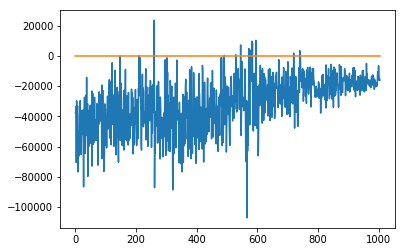

In [6]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sum_rewards_total = 0
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas+5): #rodar uma quantidade de epocas
            modelo.limpa_memoria_epoca()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            modelo.treina_modelo() #roda o modelo com toda a memoria da epoca
            sum_rewards_total += sum_rewards
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f} Epsilon = {2:0.3f}".format(epoca, sum_rewards, modelo.epsilon))
            print(dias_pos)
            print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = epsilon_min
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos_5.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
            
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca